## Project description

## import modules

In [148]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from visuals import evaluate
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,fbeta_score
from sklearn.metrics import make_scorer

from sklearn.naive_bayes  import GaussianNB
from sklearn.svm import SVC
from  sklearn.ensemble  import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier



## load data

In [300]:
with ZipFile('titanic.zip','r') as titanic:
    titanic.extractall()
    titanic.close()

In [301]:
train_df = pd.read_csv('train.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


 with intuition and general knowledege inspect pclass, sex, age with relationship of surivial rate

In [170]:
train_df[train_df['Fare'] == 512.329200]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
258,259,1,1,"Ward, Miss. Anna",NaN,35.0,0,0,PC 17755,512.3292,NaN,C,Miss
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",NaN,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Mr
737,738,1,1,"Lesurer, Mr. Gustave J",NaN,35.0,0,0,PC 17755,512.3292,B101,C,Mr


In [166]:
train_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,0.0,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,NaN,80.000000,8.000000,6.000000,512.329200


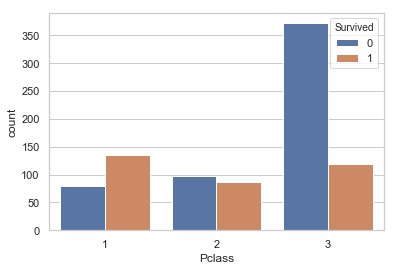

In [9]:
ax1 = sns.countplot(x = 'Pclass',hue = 'Survived',data = train_df )


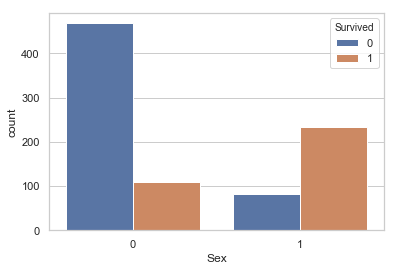

In [10]:
ax2 = sns.countplot(x = 'Sex',hue = 'Survived',data = train_df)

In [11]:
train_df['Sex'] = train_df['Sex'].map({'male':0,'female':1})

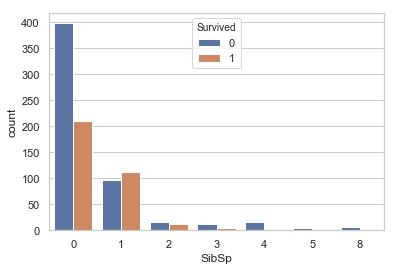

In [12]:
sns.countplot(x = 'SibSp',hue = 'Survived',data = train_df )

## Preprocess name column to generate a title column

In [302]:
def split_name(df,col_name,new_name):
    
    miss_ = ['Mlle','Ms','Mme','Lady','theCountess','Dona']
    mr_ = ['Don','Rev','Col','Major','Jonkheer','Sir','Capt']
    
#     extract out title frome col_name
    split_arr = df[col_name].str.split(',')
    result = []
    for i in range(len(split_arr)):
         result.append(split_arr[i][1].split('.')[0].replace(' ',''))
#     group the new titles
    for i in range(len(result)):
        if result[i]  in miss_:
            result[i] = 'Miss'
        elif result[i] in mr_:
            result[i] = 'Mr'
    
    df[new_name] = result
    
    return df

In [303]:
df_split = split_name(train_df,'Name','Title')

In [304]:
df_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [16]:
split_name(train_df,'Name','Title')['Title'].value_counts()



Mr        531
Miss      188
Mrs       125
Master     40
Dr          7
Name: Title, dtype: int64

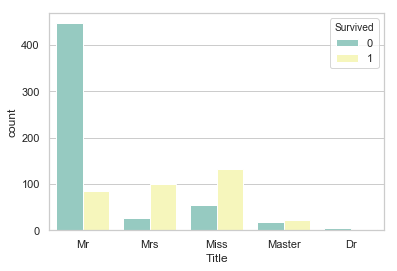

In [17]:
ax2 = sns.countplot(x = 'Title',hue = 'Survived',data = train_df,palette="Set3")

##  One hot enconding for Title columns

In [866]:
pd.cut(df_split['SibSp'],bins =[-0.1,0,1,3.0,9.0]).value_counts()

(-0.1, 0.0]    608
(0.0, 1.0]     209
(1.0, 3.0]      44
(3.0, 9.0]      30
Name: SibSp, dtype: int64

In [867]:
df_split

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Mr
5,6,0,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,NaN,Q,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,S,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,NaN,S,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,NaN,C,Mrs


In [18]:
#Proprcess fear of feature

In [30]:
train_df['Name'][train_df['Name'].str.contains('John Bradley')]

1    Cumings, Mrs. John Bradley (Florence Briggs Th...
Name: Name, dtype: object

In [31]:
train_df['Name'][train_df['Fare'] == 71.2833]

1    Cumings, Mrs. John Bradley (Florence Briggs Th...
Name: Name, dtype: object

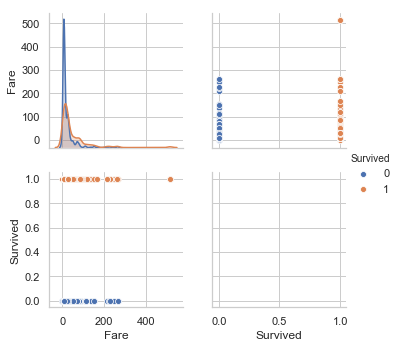

In [66]:
sns.pairplot(hue = 'Survived',data = train_df[['Fare','Survived']])

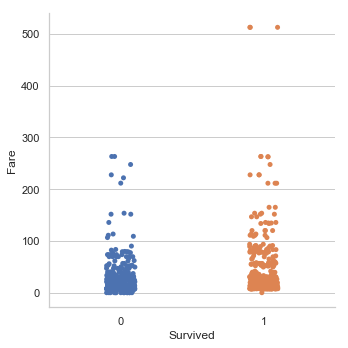

In [67]:
sns.catplot(x="Survived", y="Fare", data=pd.merge(train_df[['Survived']],cal_per_fare(train_df)))

In [68]:
# since fare it total cost for all the people travelled with,let's compute the spend per person

In [305]:
def cal_per_fare(df):
    
    per_spare = {}
    
    for i in range(len(df)):
        
        if df['SibSp'][i] ==  0 and df['Parch'][i]==  0:
            per_spare[i] = df['Fare'][i]
        else:
            per_spare[i] = df['Fare'][i] / (df['SibSp'][i] + df['Parch'][i]+1)
            
    per_spare_df = pd.DataFrame(list(per_spare.items()),columns = ['index','per_spare'],index = list(per_spare.keys()))
#     per_spare_df.reset_index(inplace =True)
    per_spare_df.set_index('index',inplace = True)
    
    return per_spare_df
        
        

In [306]:
pair_fare_sur = pd.merge(train_df[['Survived']],cal_per_fare(train_df),left_index = True,right_index = True)

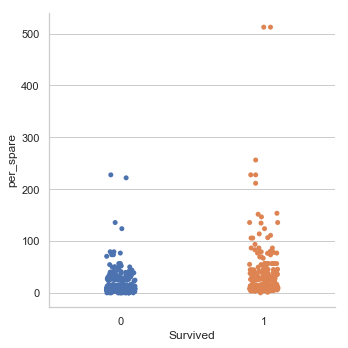

In [307]:
sns.catplot(x="Survived", y="per_spare", data=pair_fare_sur)

In [334]:
def df_features(df,featrue_cols):
    
    pre_train_df = df[featrue_cols]
#     pre_train_df['SibSp'] = pd.cut(pre_train_df['SibSp'],bins =[-0.1,0,1,3.0,9.0])
#     convert title to dummy variables
    titles = pd.get_dummies(pre_train_df['Title'])
#     convert 'sibsp' to dummy vaiables
#     sip = pd.get_dummies(pre_train_df['SibSp'],prefix = 'Sip')
#      convert sex to dummy vairables
#     sex = pd.get_dummies(pre_train_df['Sex'],prefix = 'Sex')
#     merge tiltes with pre_train_df
    pre_train_df = pd.merge(pre_train_df,titles,left_index =True,right_index =True)
#     merge sips  with pre_train_df    
#     pre_train_df = pd.merge(pre_train_df,sex,left_index =True,right_index =True)
#     pre_train_df = pd.merge(pre_train_df,sip,left_index =True,right_index =True)
    per_fare = cal_per_fare(pre_train_df)
    per_fare = pd.qcut(per_fare['per_spare'],q = 10)
    per_fare = pd.get_dummies(per_fare,prefix = 'fare')
    
    pre_train_df = pd.merge(pre_train_df,per_fare,left_index =True,right_index =True)
    pre_train_df.drop(['Title','Fare','SibSp','Parch'],axis = 1,inplace =True)
    
    return pre_train_df

In [335]:
per_fare = cal_per_fare(train_df)
per_fare = pd.qcut(per_fare['per_spare'],q = 7)

In [336]:
pre_train_df = df_features(df_split,featrue_cols = ['Title','Pclass','Fare','SibSp','Parch'])

##  split dataset as train and valiation

In [337]:
X = pre_train_df
y = train_df['Survived']

In [338]:
X_train, X_valid, y_train,y_valid = train_test_split(X,y,test_size = 0.2,random_state = 42,stratify = y)

In [339]:
sum(y_train ==1) / len(y_train) *100

38.342696629213485

In [340]:
sum(y_valid ==1) / len(y_valid) *100

38.547486033519554

##  Evaluating Model Performance

In this case, model is capable to predict the one survied or not is equally important, then we use **accuracy for** evaluating the model, but ture positive and true negative is imporant.

## Naieve model

In [341]:
# we can have a naive model to predict all the passengers will survived.
TP = np.sum(y)
FP = len(y) - TP

TN = 0
FN = 0

#  Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP+FP+TN +FN )
# accuracy
recall = TP / (TP + FN)
precision = TP/(TP + FP)

# # Calculate F-score using the formula above for beta = 1 and correct values for precision and recall.
fscore = (1+1**2)*(precision * recall  / (1**2*precision + recall))

# # Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3838, F-score: 0.5547]


## Training Function

In [342]:
def train_and_validation(learner,x_train,y_train,x_valid,y_valid):

    '''
    inputs:
    - learner: the learning algorithm to be trained and predicted on
    - X_train: features training set
    - y_train: survived training set
    - X_valid: features testing set
    - y_valid: survived testing set
    '''
    result = {}
    learner.fit(x_train,y_train)

    #     get the prediction on validation and train datasets
    pred_valid = learner.predict(x_valid)
    pred_train = learner.predict(x_train)
#     print('pred_valid',pred_valid)

    #     get the accuracy score and f_beta score for 
    result['acc_valid'] = accuracy_score(y_true = y_valid,y_pred = pred_valid)
    print('accuracy score',accuracy_score(y_true = y_valid,y_pred = pred_valid))
    result['f_valid'] = fbeta_score(y_true = y_valid,y_pred = pred_valid,beta = 1)

    print("{} trained on .".format(learner.__class__.__name__))
    return result
    

## Train on classifier

In [343]:


clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = RandomForestClassifier(random_state = 42)
# clf_D = XGBClassifier()

results = {}
for clf in [clf_A, clf_B,clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_and_validation(clf,  X_train, y_train, X_valid, y_valid)

# Run metrics visualization for the three supervised learning models chosen
results = pd.DataFrame(results)

accuracy score 0.7597765363128491
GaussianNB trained on .
accuracy score 0.8156424581005587
AdaBoostClassifier trained on .
accuracy score 0.7932960893854749
RandomForestClassifier trained on .


D:\Program Files (x86)\conda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [344]:
results

,GaussianNB,AdaBoostClassifier,RandomForestClassifier
acc_valid,0.759777,0.815642,0.793296
f_valid,0.715232,0.740157,0.704000


In [345]:
## Grid search on adaboost classifer

clf = AdaBoostClassifier(random_state = 42)
base_est = [ExtraTreeClassifier(),DecisionTreeClassifier()]
# searching paratmeters and scoring
parameters = {'base_estimator':base_est, 'n_estimators': [5,10,20,50,100,200], 'learning_rate': [0.001,0.01,0.3,0.5,1,10] }
scorer = make_scorer(accuracy_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV( clf, parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_valid)
best_predictions = best_clf.predict(X_valid)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_valid, best_predictions)))


D:\Program Files (x86)\conda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8156

Optimized Model
------
Final accuracy score on the testing data: 0.7933


##  Predict on test data with Clf_A

In [289]:
test_df = pd.read_csv('test.csv')

In [290]:

df_split = split_name(test_df,'Name','Title')
pre_df = df_features(df_split,featrue_cols = ['Title','Pclass','SibSp','Sex'])


KeyError: 'Parch'

In [894]:
test_df['Survived'] = clf_A.predict(pre_df)

## Write predction result to CSV file

In [832]:
test_df[['Survived','PassengerId']].to_csv('Passenger_submission_1.csv',index =False)